# Building a GPT-Style Decoder from Scratch

## 1. Introduction

In this notebook, we will demystify **Decoder-Only Models**. These are the architectures behind the generative AI revolution (GPT-3, ChatGPT, LLaMA, Claude).

While Encoders (like BERT) are great at *understanding* text, Decoders are built for *generation*. They predict the next token in a sequence based on the history.

### The Goal
We will build a model that reads the works of **William Shakespeare** and learns to generate new plays in his style, character by character.

### Key Concepts You Will Implement:
1.  **Causal Masking**: The "secret sauce" that prevents the model from cheating by looking into the future.
2.  **The Decoder Block**: Combining Masked Self-Attention with Feed-Forward networks.
3.  **Autoregressive Generation**: The loop of predicting a token, adding it to the input, and predicting again.
4.  **Temperature Sampling**: Controlling the creativity of the AI.

Let's begin!

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import requests

# Set random seed for reproducibility
torch.manual_seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. The Causal Mask (The "No Peeking" Rule)

The most critical difference between a standard Attention block and a Decoder is the **Causal Mask**.

When the model tries to predict the word at position 4, it should see positions 1, 2, and 3. It should **not** see position 5. If it sees position 5, it's not predicting; it's cheating.

We achieve this by setting the attention scores of future tokens to `-infinity`. When we apply Softmax, these become `0`.

**Visualizing the Mask:**
We want a triangular matrix where the upper right is blocked.

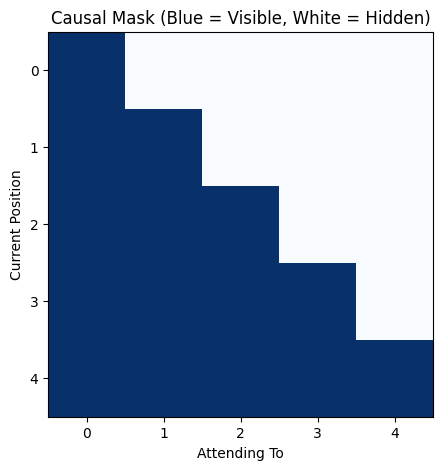

Actual Mask Values:
 tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [5]:
def generate_causal_mask(sz):
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag and below.
    Shape: [sz, sz]
    """
    # Create a mask with 1s in the upper triangle
    mask = torch.triu(torch.ones(sz, sz), diagonal=1)
    
    # Replace 1s with -inf, and 0s with 0
    mask = mask.masked_fill(mask == 1, float('-inf'))
    
    return mask

# Let's visualize a mask for a sentence of 5 words
seq_len = 5
mask = generate_causal_mask(seq_len)

plt.figure(figsize=(5,5))
plt.imshow(mask == 0, cmap='Blues') # Plotting boolean for visibility
plt.title("Causal Mask (Blue = Visible, White = Hidden)")
plt.ylabel("Current Position")
plt.xlabel("Attending To")
plt.xticks(range(seq_len))
plt.yticks(range(seq_len))
plt.grid(False)
plt.show()

print("Actual Mask Values:\n", mask)

## 3. Data Preparation: Tiny Shakespeare

We will use a character-level tokenizer. This means our "vocabulary" is just the list of unique characters (letters, punctuation) in the text. This is simpler than word-level tokenization and allows the model to create new words.

In [7]:
# 1. Download the data
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
data = requests.get(url).text

print(f"Length of dataset: {len(data)} characters")

# 2. Build Vocabulary
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")
print(f"Vocab: {''.join(chars)}")

# 3. Mappings
stoi = { ch:i for i,ch in enumerate(chars) } # String to Index
itos = { i:ch for i,ch in enumerate(chars) } # Index to String

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Test
print(f"\nEncoded 'hello': {encode('hello')}")
print(f"Decoded: {decode(encode('hello'))}")

# 4. Convert entire text to tensor
data = torch.tensor(encode(data), dtype=torch.long)
train_data = data[:int(0.9*len(data))] # 90% Train
val_data = data[int(0.9*len(data)):]   # 10% Validation

Length of dataset: 1115394 characters
Vocabulary size: 65
Vocab: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Encoded 'hello': [46, 43, 50, 50, 53]
Decoded: hello


### 3.1 Batch Generation

In a decoder, **Input** is `Sequence[0 -> T-1]`, and **Target** is `Sequence[1 -> T]`.

Example Sentence: "HELLO"
- Input: "HELL"
- Target: "ELLO" 

The model learns: given 'H', predict 'E'; given 'HE', predict 'L', etc.

In [8]:
batch_size = 32 # How many independent sequences will we process in parallel?
block_size = 64 # What is the maximum context length for predictions?

def get_batch(split):
    # Select data source
    data_source = train_data if split == 'train' else val_data
    
    # Generate random starting positions
    ix = torch.randint(len(data_source) - block_size, (batch_size,))
    
    # Stack inputs (x) and targets (y)
    x = torch.stack([data_source[i:i+block_size] for i in ix])
    y = torch.stack([data_source[i+1:i+block_size+1] for i in ix])
    
    return x.to(device), y.to(device)

xb, yb = get_batch('train')
print("Inputs shape:", xb.shape)
print("Targets shape:", yb.shape)
print(f"Input example: {decode(xb[0].tolist())}")
print(f"Target example: {decode(yb[0].tolist())}")

Inputs shape: torch.Size([32, 64])
Targets shape: torch.Size([32, 64])
Input example: Paris!
What said my man, when my betossed soul
Did not attend hi
Target example: aris!
What said my man, when my betossed soul
Did not attend him


## 4. The Model Architecture

We will build a **Transformer Decoder**. 

Technically, in PyTorch, the standard `TransformerDecoder` includes Cross-Attention (for translation). Since we are doing **GPT-style generation** (just text generation, no translation source), we actually use `TransformerEncoderLayer` logic but apply the **Causal Mask**.

To make this crystal clear, we will wrap the logic in a clean `DecoderOnlyTransformer` class.

In [9]:
class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding"""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create matrix of [SeqLen, HiddenDim] representing position
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a learnable parameter, but part of state_dict)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: [Batch, SeqLen, HiddenDim]
        return x + self.pe[:, :x.size(1), :]

class GPTDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0.1):
        super().__init__()
        
        # 1. Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncoding(d_model, max_len=block_size)
        
        # 2. The Transformer Layers
        # We use TransformerEncoderLayer because we only need Self-Attention
        # The "Decoder" aspect comes from the MASK we pass during forward()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True # Expect [Batch, Seq, Feature]
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Final Norm & Output Head
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # 1. Embed Token + Position
        x = self.token_embedding(idx)
        x = self.position_encoding(x)

        # 2. Create Causal Mask
        # The mask must be on the same device as the input
        mask = generate_causal_mask(T).to(idx.device)

        # 3. Pass through Transformer with Mask
        # is_causal=True is a hint for optimization in newer PyTorch, 
        # but passing mask explicitly is the classic robust way.
        x = self.transformer(x, mask=mask)
        x = self.ln_f(x)

        # 4. Project to Vocab Size
        logits = self.head(x) # Shape: [Batch, SeqLen, VocabSize]

        # 5. Calculate Loss (if targets provided)
        loss = None
        if targets is not None:
            # Flatten predictions and targets for CrossEntropy
            # Logits: [B*T, Vocab], Targets: [B*T]
            loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1))

        return logits, loss

## 5. Training

We will initialize a small model (for speed) and train it. With a GPU, this should take a minute or two to start seeing recognizable English.

In [10]:
# Model Hyperparameters
d_model = 256     # Hidden dimension size
nhead = 4         # Number of attention heads
num_layers = 4    # Number of transformer blocks
learning_rate = 3e-4
max_iters = 2000
eval_interval = 200

model = GPTDecoder(vocab_size, d_model, nhead, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"The model has {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

The model has 3.19M parameters


In [11]:
# Training Loop
print("Starting training...")

for iter in range(max_iters):
    
    # Sample a batch of data
    xb, yb = get_batch('train')

    # Forward pass
    logits, loss = model(xb, yb)

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Logging
    if iter % eval_interval == 0:
        print(f"Step {iter}: Loss {loss.item():.4f}")

print("Training Complete!")

Starting training...
Step 0: Loss 4.4646
Step 200: Loss 2.2433
Step 400: Loss 2.0711
Step 600: Loss 1.9214
Step 800: Loss 1.8073
Step 1000: Loss 1.7586
Step 1200: Loss 1.7676
Step 1400: Loss 1.6728
Step 1600: Loss 1.6746
Step 1800: Loss 1.5758
Training Complete!


## 6. Generation: Creating New Text

Unlike training (where we do everything in parallel), generation is a loop:
1. Feed current sequence.
2. Get logit for the *last* token.
3. Apply Softmax to get probabilities.
4. **Sample** a new index based on probabilities.
5. Append new index to sequence.
6. Repeat.

### Temperature
We use `temperature` to control randomness.
- `temp < 1`: Makes the distribution sharper (model becomes more confident/conservative).
- `temp > 1`: Flattens the distribution (model takes more risks/is more creative).

In [12]:
def generate_text(model, start_str, max_new_tokens=200, temperature=1.0):
    # 1. Encode starting string to tensor
    idx = torch.tensor(encode(start_str), dtype=torch.long, device=device).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Cropping: If sequence exceeds block_size, keep only the last block_size tokens
            idx_cond = idx[:, -block_size:]
            
            # Get predictions
            logits, _ = model(idx_cond)
            
            # Focus only on the last time step
            logits = logits[:, -1, :] / temperature
            
            # Apply softmax
            probs = F.softmax(logits, dim=-1)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)

    return decode(idx[0].tolist())

In [13]:
print("--- Generated Shakespeare (Temp 0.8) ---")
print(generate_text(model, start_str="ROMEO: ", max_new_tokens=300, temperature=0.8))

print("\n--- Generated Shakespeare (Temp 0.2 - Conservative) ---")
print(generate_text(model, start_str="ROMEO: ", max_new_tokens=300, temperature=0.2))

--- Generated Shakespeare (Temp 0.8) ---
ROMEO: I crome to go Romeo, sir.

FRIAR LAURENCE:
What could lost do much for the farewter to bless
your ender time, is he loved any coundrat thou art
Are for speaks, sir.

ROMEO:
Here do mistress and light, parging at despare what
Shall be a leing to this first a baning my good
this never bower than tway 

--- Generated Shakespeare (Temp 0.2 - Conservative) ---
ROMEO: I have we so shall be the some of the brother,
And the speak of the fair of the soul,
And by the some of the stand of the cannot
That be the stand of the brother to be the country.

QUEEN MARGARET:
What shall be the more to me to so my lord.

KING EDWARD IV:
What I will not the some of the commmon o


## 7. Conclusion

You have successfully built a generative Transformer from scratch!

### Key Takeaways:
1.  **Decoders generate autoregressively**: They need the immediate past to predict the immediate future.
2.  **Masking is crucial**: The Causal Mask ensures the logic holds during parallel training.
3.  **Scale matters**: We used a tiny model (~1M params). GPT-3 has 175 Billion. The architecture is nearly identical; the difference is data and size.

**Extensions:**
- Try increasing `num_layers` and `d_model` and training for longer.
- Try implementing "Top-K" sampling in the generation function to prevent the model from picking very unlikely words.